In [34]:
import easyocr
import cv2
import matplotlib.pyplot as plt
import re
from textdistance import levenshtein
from collections import Counter
import numpy as np
from spellchecker import SpellChecker
from IPython.display import display, HTML

In [35]:
class MangaAutocorrect:
    def __init__(self):
        self.spell = SpellChecker()
        # Add manga-specific words
        self.spell.word_frequency.load_words([
            'hurry', 'scaaary', 'ahhh', 'whoa', 'boom', 
            'pow', 'nyaa', 'gasp', 'ugh', 'hmph', 'pant',
            'sigh', 'grr', 'meow', 'rawr', 'zap', 'wham'
        ])
    
    def autocorrect_word(self, word):
        if not word.isalpha():
            return word
        return self.spell.correction(word) or word
    
    def autocorrect_text(self, text):
        tokens = re.findall(r"[\w'-]+|[.!?,]", text)
        return ' '.join(
            self.autocorrect_word(token) if token.isalpha() else token
            for token in tokens
        ).replace(' ,', ',').replace(' .', '.').replace(' !', '!')

In [36]:
def process_manga_page(image_path, min_confidence=0.4):
    reader = easyocr.Reader(['en'])
    autocorrect = MangaAutocorrect()
    
    results = reader.readtext(image_path,
                            batch_size=1,
                            text_threshold=0.6,
                            low_text=0.4,
                            link_threshold=0.4,
                            mag_ratio=1.5)
    
    final_results = []
    for (bbox, text, prob) in results:
        if prob >= min_confidence:
            corrected = autocorrect.autocorrect_text(text)
            final_results.append((bbox, corrected, prob))
    
    return final_results

In [37]:
def show_results(image_path, results):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 1, 1)
    ax.imshow(image_rgb)
    
    for (bbox, text, prob) in results:
        (tl, tr, br, bl) = bbox
        tl = (int(tl[0]), int(tl[1]))
        br = (int(br[0]), int(br[1]))
        
        rect = plt.Rectangle((tl[0], tl[1]), 
                           br[0]-tl[0], br[1]-tl[1],
                           fill=False, edgecolor='lime', linewidth=2)
        ax.add_patch(rect)
        
        ax.text(tl[0], tl[1]-10, f"{text} ({prob:.0%})",
               bbox=dict(facecolor='lime', alpha=0.8),
               fontsize=12, color='black')
    
    plt.axis('off')
    plt.show()
    
    print("\nCORRECTED TEXT:")
    for i, (_, text, prob) in enumerate(results, 1):
        print(f"{i}. {text} (confidence: {prob:.0%})")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


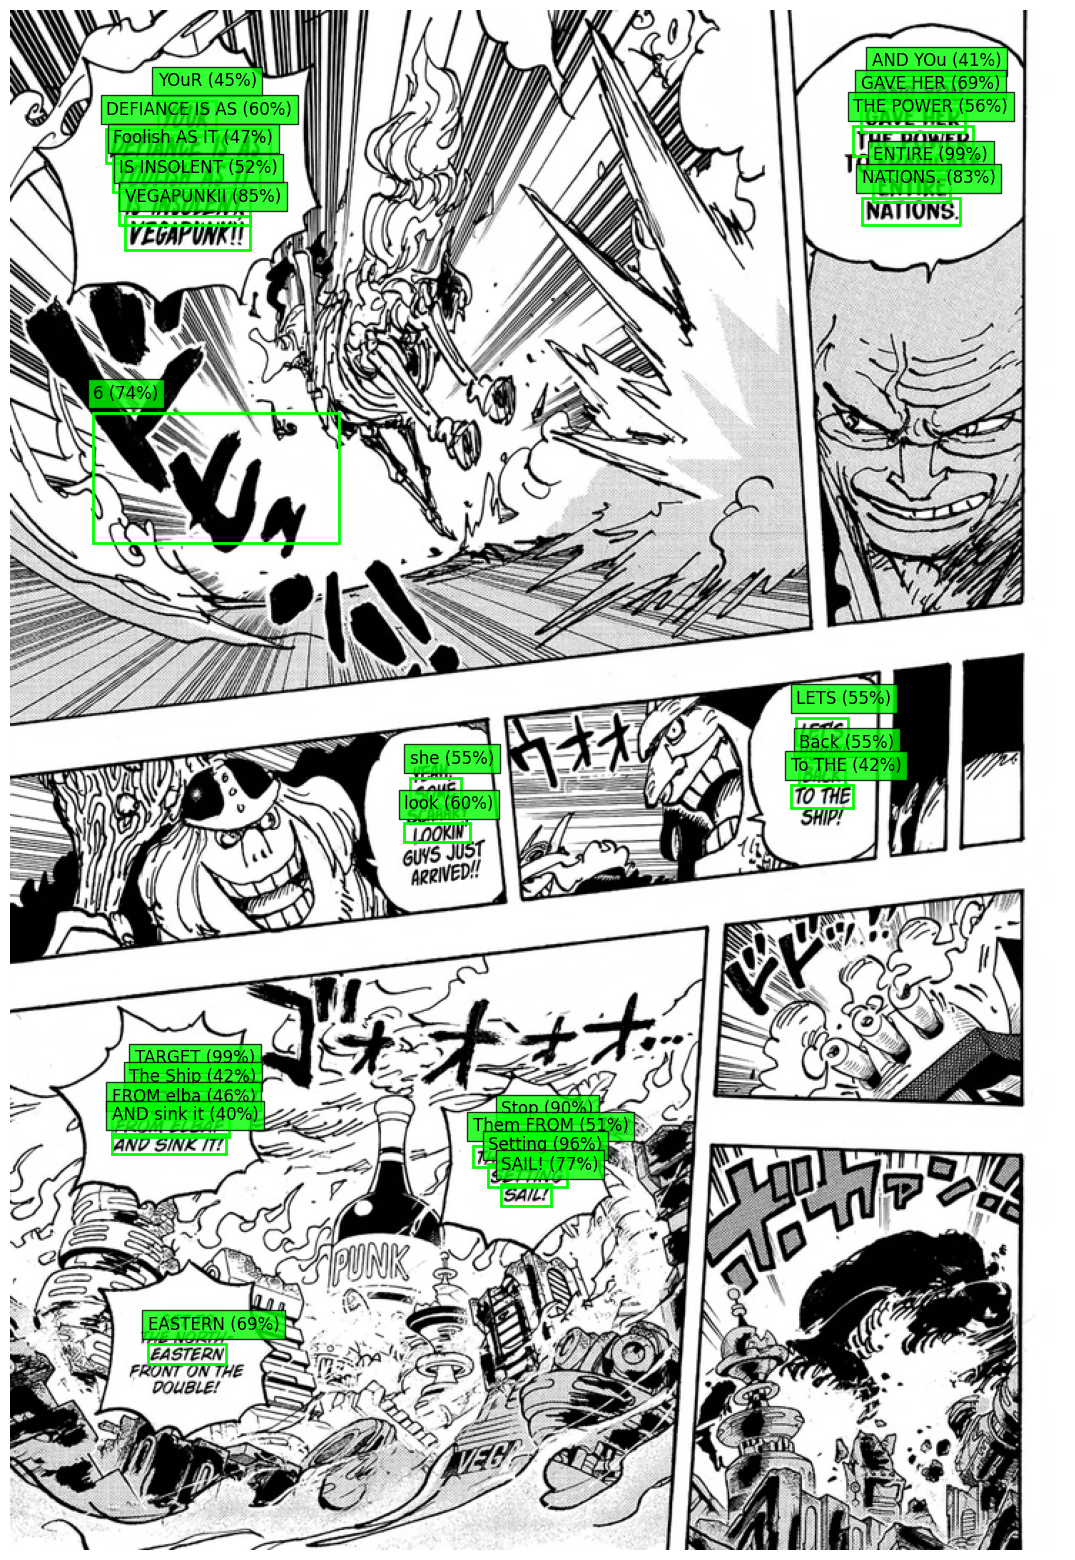


CORRECTED TEXT:
1. AND YOu (confidence: 41%)
2. YOuR (confidence: 45%)
3. GAVE HER (confidence: 69%)
4. DEFIANCE IS AS (confidence: 60%)
5. THE POWER (confidence: 56%)
6. Foolish AS IT (confidence: 47%)
7. ENTIRE (confidence: 99%)
8. IS INSOLENT (confidence: 52%)
9. NATIONS. (confidence: 83%)
10. VEGAPUNKII (confidence: 85%)
11. LETS (confidence: 55%)
12. Back (confidence: 55%)
13. she (confidence: 55%)
14. To THE (confidence: 42%)
15. TARGET (confidence: 99%)
16. The Ship (confidence: 42%)
17. FROM elba (confidence: 46%)
18. AND sink it (confidence: 40%)
19. Stop (confidence: 90%)
20. Them FROM (confidence: 51%)
21. Setting (confidence: 96%)
22. SAIL! (confidence: 77%)
23. EASTERN (confidence: 69%)
24. 6 (confidence: 74%)
25. look (confidence: 60%)


In [38]:
# Replace with your manga image path
IMAGE_PATH = "/home/daniel/Desktop/op_reader/TEST.jpg"  # Place in same folder as notebook

# Process and display results
results = process_manga_page(IMAGE_PATH)
show_results(IMAGE_PATH, results)

# %%
# 7. (OPTIONAL) BATCH PROCESS MULTIPLE PAGES
import os

def process_manga_folder(folder_path):
    all_results = {}
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            results = process_manga_page(image_path)
            all_results[filename] = results
            print(f"\nProcessed {filename}:")
            show_results(image_path, results)
    return all_results

In [39]:
# Print extracted text with formatting
print("\nExtracted Text:")
print("-" * 50)
for i, (_, text, prob) in enumerate(results, 1):
    print(f"{i}. {text} (confidence: {prob:.2%})")
print("-" * 50)
print(f"\nTotal text blocks detected: {len(results)}")


Extracted Text:
--------------------------------------------------
1. AND YOu (confidence: 41.08%)
2. YOuR (confidence: 45.04%)
3. GAVE HER (confidence: 69.46%)
4. DEFIANCE IS AS (confidence: 60.28%)
5. THE POWER (confidence: 55.69%)
6. Foolish AS IT (confidence: 46.84%)
7. ENTIRE (confidence: 99.20%)
8. IS INSOLENT (confidence: 52.11%)
9. NATIONS. (confidence: 82.89%)
10. VEGAPUNKII (confidence: 85.35%)
11. LETS (confidence: 55.36%)
12. Back (confidence: 54.86%)
13. she (confidence: 55.35%)
14. To THE (confidence: 42.44%)
15. TARGET (confidence: 99.33%)
16. The Ship (confidence: 42.00%)
17. FROM elba (confidence: 46.28%)
18. AND sink it (confidence: 40.35%)
19. Stop (confidence: 89.92%)
20. Them FROM (confidence: 50.76%)
21. Setting (confidence: 96.22%)
22. SAIL! (confidence: 76.85%)
23. EASTERN (confidence: 69.25%)
24. 6 (confidence: 74.30%)
25. look (confidence: 59.82%)
--------------------------------------------------

Total text blocks detected: 25
